# 

# ZOIDBERG 2.0

https://www.tensorflow.org/tutorials/images/classification


classification d'image

- SVM
- Dense
- Convolution CNN

- Optimisation d'hyper parametre (yavait un truc auto)

- Essayer du non supervisé ?

- AUgmentation d'image (symmetrie / rotation)

- Beaucoup de validation / chiffre, explication
- vrai evalution / etude comparative

- comparer plusieurs modèles

- connaitre tout les models du bouquin

TODO:
- Demander qu'est-ce qu'il veut dans le gros compte rendu
- pas assez de donnee de validation : les split nous meme

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# test tensorflow installation cpu
print(tf.reduce_sum(tf.random.normal([1000,1000])))

tf.Tensor(201.2601, shape=(), dtype=float32)


In [6]:
print(tf.version.VERSION)

2.12.0


## 1. Load X-rays data

In [5]:
# import librairies
from tensorflow import keras
from keras.utils import image_dataset_from_directory

In [9]:
batch_size = 32 # number of epochs
img_height = 256
img_width = 256

train_data_dir = '../data/chest_Xray/train'
val_data_dir = '../data/chest_Xray/val'

train_ds = image_dataset_from_directory(
    directory= train_data_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    directory= val_data_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


In [12]:
class_names = train_ds.class_names
print(class_names)


['NORMAL', 'PNEUMONIA']


## 2. Visualize the data
blablabla

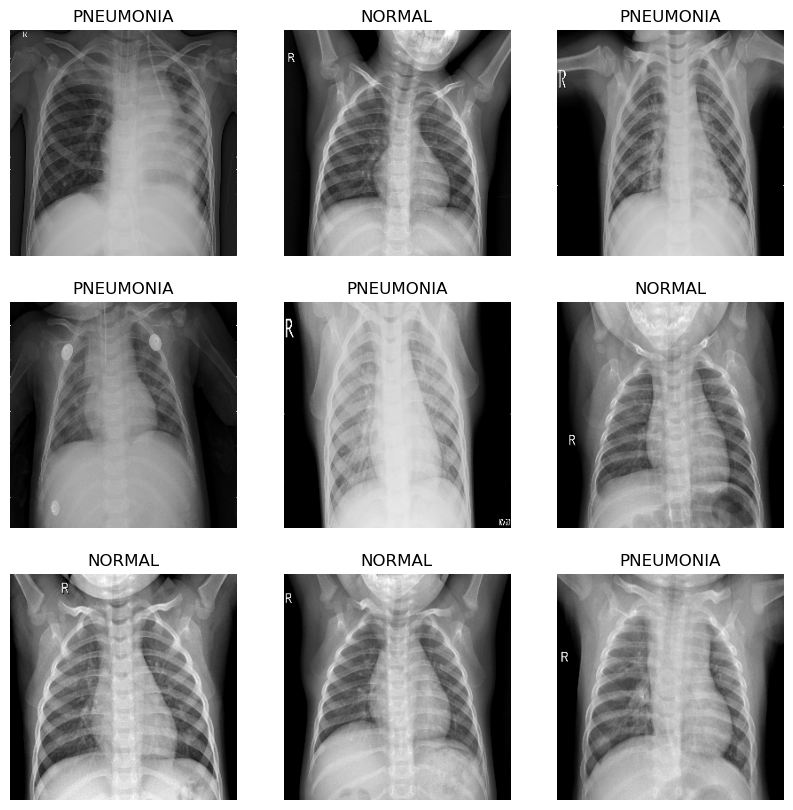

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [15]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 256, 256, 3)
(32,)


## 3. Configure the dataset for performance


In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 4. Standardize the data

In [18]:
# actual RGB: [0,255] --> , [0,1]

from keras import layers

normalization_layer = layers.Rescaling(1./255)

In [19]:
# use the layer
# you can apply it to the dataset by calling Dataset.map
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`
print(np.min(first_image), np.max(first_image))

# or directly in the model


0.0 1.0


## 5. Model

In [20]:
from keras.engine.sequential import Sequential


num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [21]:
# compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1

In [23]:
# train the model
epochs=10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
163/163 [==============================] - 139s 842ms/step - loss: 0.1909 - accuracy: 0.9277 - val_loss: 0.2140 - val_accuracy: 0.8125
Epoch 2/10
163/163 [==============================] - 173s 1s/step - loss: 0.0798 - accuracy: 0.9707 - val_loss: 0.0569 - val_accuracy: 1.0000
Epoch 3/10
163/163 [==============================] - 240s 1s/step - loss: 0.0624 - accuracy: 0.9789 - val_loss: 0.3274 - val_accuracy: 0.7500
Epoch 4/10
163/163 [==============================] - 156s 957ms/step - loss: 0.0491 - accuracy: 0.9808 - val_loss: 0.2828 - val_accuracy: 0.8125
Epoch 5/10
163/163 [==============================] - 162s 992ms/step - loss: 0.0394 - accuracy: 0.9854 - val_loss: 0.0425 - val_accuracy: 1.0000
Epoch 6/10
163/163 [==============================] - 158s 966ms/step - loss: 0.0260 - accuracy: 0.9898 - val_loss: 0.0581 - val_accuracy: 1.0000
Epoch 7/10
163/163 [==============================] - 185s 1s/step - loss: 0.0180 - accuracy: 0.9931 - val_loss: 0.0655 - val_accu

## Validating training results

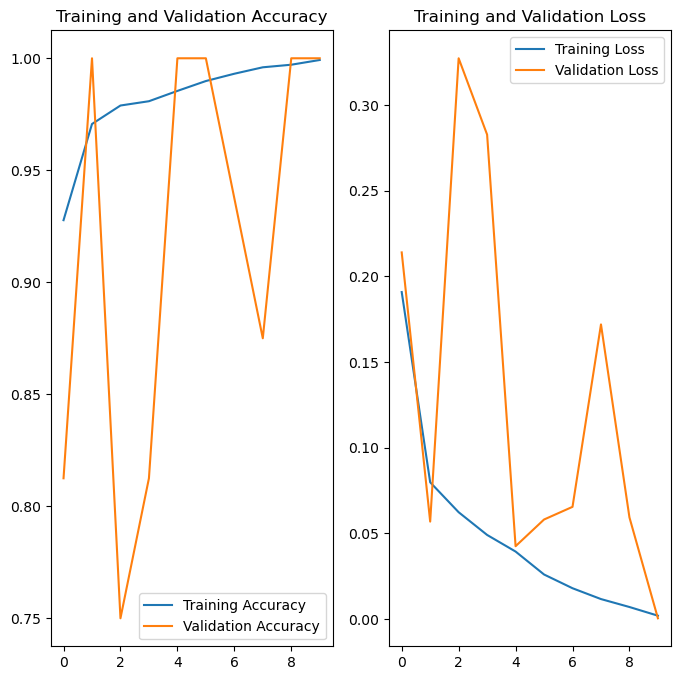

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


# TEST

In [26]:
from keras.utils.image_utils import img_to_array, load_img


img = load_img(
    "../data/chest_Xray/test/PNEUMONIA/person100_bacteria_475.jpeg",
    target_size=(img_height, img_width)
)
img_array = img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


1/1 [==============================] - 0s 34ms/step
This image most likely belongs to PNEUMONIA with a 100.00 percent confidence.
